# **Exploratory Data Analysis**

This notebook aims to perform Exploratory Data Analysis (EDA) on train delay data to identify key patterns, trends, and potential features for predictive modeling. 

By conducting a thorough EDA, we will:
- Identify missing values and data inconsistencies
- Analyze delay distributions and detect anomalies
- Explore time-based trends (rush hours, weekdays vs. weekends)
- Examine correlations between different variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
INTERIM_PATH = Path("data/interim")
df = pd.read_parquet(INTERIM_PATH / "train_data_cleaned.parquet")

In [3]:
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())

df.head()

Dataset Shape: (27973425, 11)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27973425 entries, 0 to 27973424
Data columns (total 11 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   train_number              object        
 1   departure_station         object        
 2   train_departure_delay     float64       
 3   arrival_station           object        
 4   scheduled_departure_time  datetime64[ns]
 5   scheduled_arrival_time    datetime64[ns]
 6   stop_name                 object        
 7   stop_arrival_delay        float64       
 8   stop_departure_delay      float64       
 9   stop_departure_time       datetime64[ns]
 10  is_terminal_stop          bool          
dtypes: bool(1), datetime64[ns](3), float64(3), object(4)
memory usage: 2.1+ GB
None


,train_number,departure_station,train_departure_delay,arrival_station,scheduled_departure_time,scheduled_arrival_time,stop_name,stop_arrival_delay,stop_departure_delay,stop_departure_time,is_terminal_stop
0,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,BOLOGNA C.LE,0.0,1.0,2024-09-30 22:38:00,True
1,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,S.LAZZARO DI SAVENA,2.0,2.0,2024-09-30 22:46:00,False
2,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,OZZANO DELL'EMILIA,3.0,2.0,2024-09-30 22:52:00,False
3,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,CASTEL S.PIETRO TERME,3.0,4.0,2024-09-30 22:59:00,False
4,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,IMOLA,3.0,4.0,2024-09-30 23:08:00,False


This dataset contains information about train journeys (for the entire year 2024), including their schedules, delays, and stop details. It includes the following key attributes:  

- **Train and Route Information**: Unique train ID (`train_id`), train number (`train_number`), departure and arrival stations (`departure_station`, `arrival_station`), and train class (`train_class`).  
- **Timing and Delays**: Scheduled departure and arrival times (`scheduled_departure_time`, `scheduled_arrival_time`), as well as departure and arrival delays at both the train level (`train_departure_delay`) and stop level (`stop_arrival_delay`, `stop_departure_delay`).  
- **Stops and Platforms**: Stop name (`stop_name`), platform at arrival (`train_arrival_platform`), actual stop arrival and departure times (`stop_arrival_time`, `stop_departure_time`), and whether the stop is the terminal station (`is_terminal_stop`).  

**Handling Missing Data**

Heatmap of missing values helps visualize patterns of missingness.

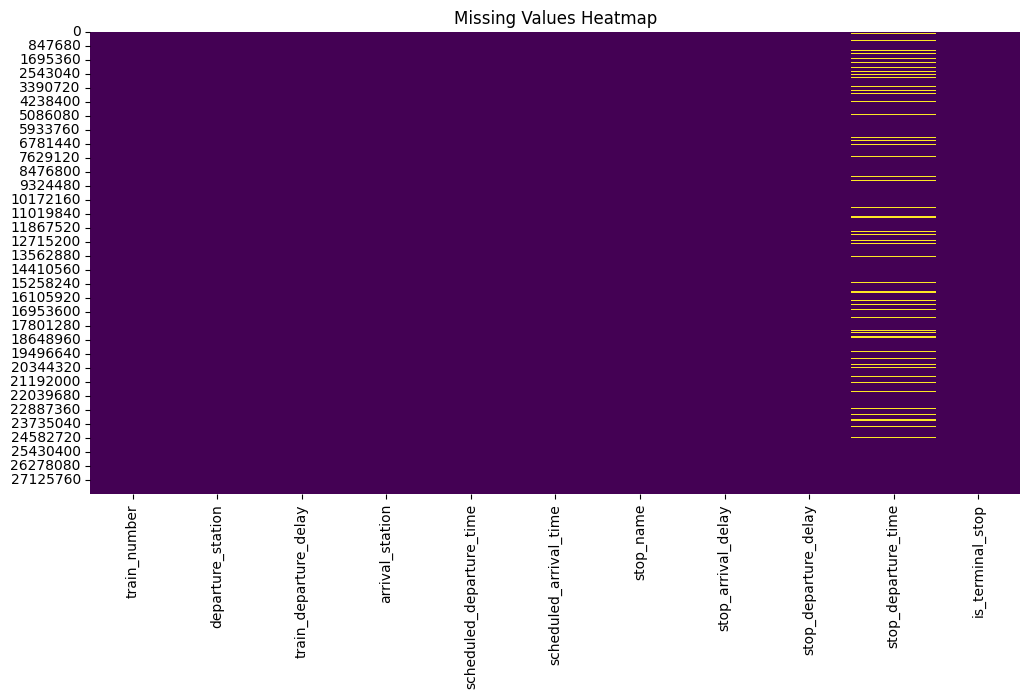


Missing Data Summary:
                          Missing Values  Percentage
stop_departure_time              2774884        9.92
departure_station                      0        0.00
train_number                           0        0.00
train_departure_delay                  0        0.00
arrival_station                        0        0.00
scheduled_arrival_time                 0        0.00
scheduled_departure_time               0        0.00
stop_name                              0        0.00
stop_arrival_delay                     0        0.00
stop_departure_delay                   0        0.00
is_terminal_stop                       0        0.00


In [4]:
# Visualizing missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Count and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_percentage.round(2)
}).sort_values(by="Percentage", ascending=False)

print("\nMissing Data Summary:")
print(missing_summary)


**Delay Distributions**

This will show if delay distributions follow a normal pattern or skewed towards high delays.
If we find extreme outliers, we might cap or transform the data.

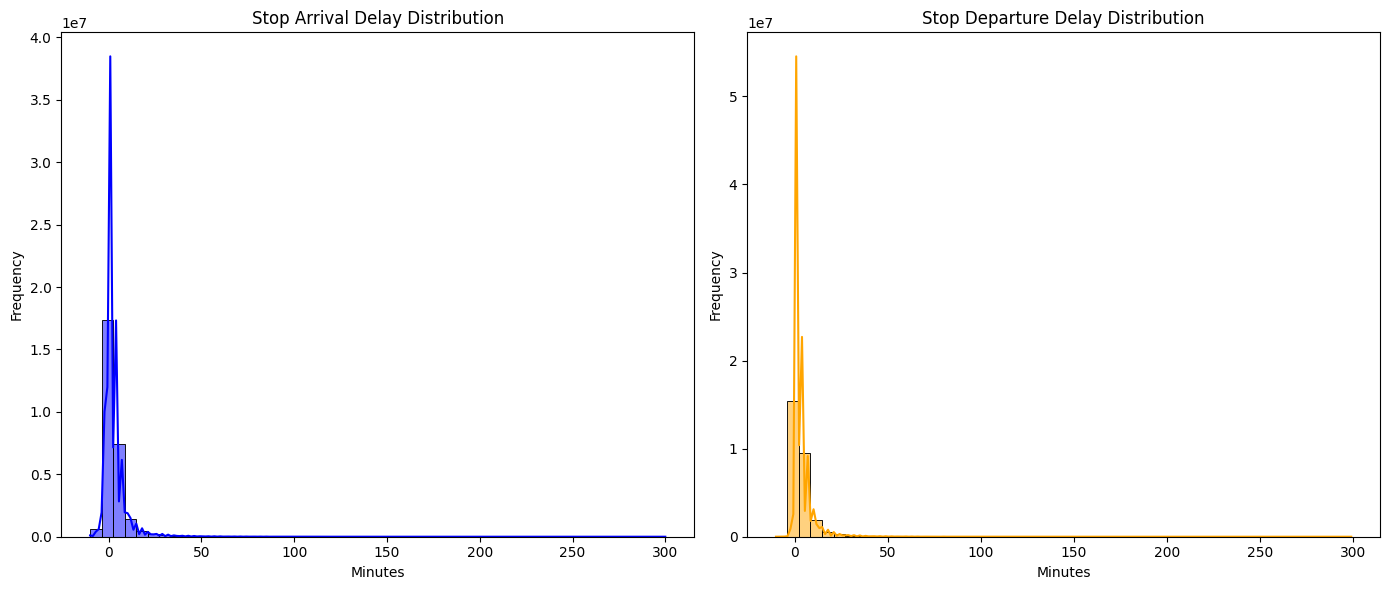

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df["stop_arrival_delay"].dropna(), bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Stop Arrival Delay Distribution")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Frequency")

sns.histplot(df["stop_departure_delay"].dropna(), bins=50, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Stop Departure Delay Distribution")
axes[1].set_xlabel("Minutes")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The two histograms represent the distribution of train delays for arrival (left, blue) and **departure** (right, yellow). 

Both histograms show a highly right-skewed distribution, meaning that delays are common, severe delays are exceptional. Infact:
  - Most delays are small (close to 0 minutes)
  - A few extreme delays (over 50 minutes) exist but are rare

Also, the departure delay histogram (right) has a higher peak, suggesting that more trains tend to experience small departure delays than arrival delays.

Both histograms show a long tail extending beyond 100 minutes, meaning some trains experience very long delays.

The KDE line suggests that delays are not perfectly normally distributed and have multiple small peaks, indicating different patterns or causes of delays.

**Identify Congested Routes**

Train networks are highly interconnected, meaning a delay at one station can propagate across the network.

A busy hub might introduce systematic delays because of frequent train arrivals and departures.
Trains waiting for other delayed trains further amplify the issue. 
If we identify which routes consistently suffer delays, we can predict and adjust expectations for subsequent stations more accurately.

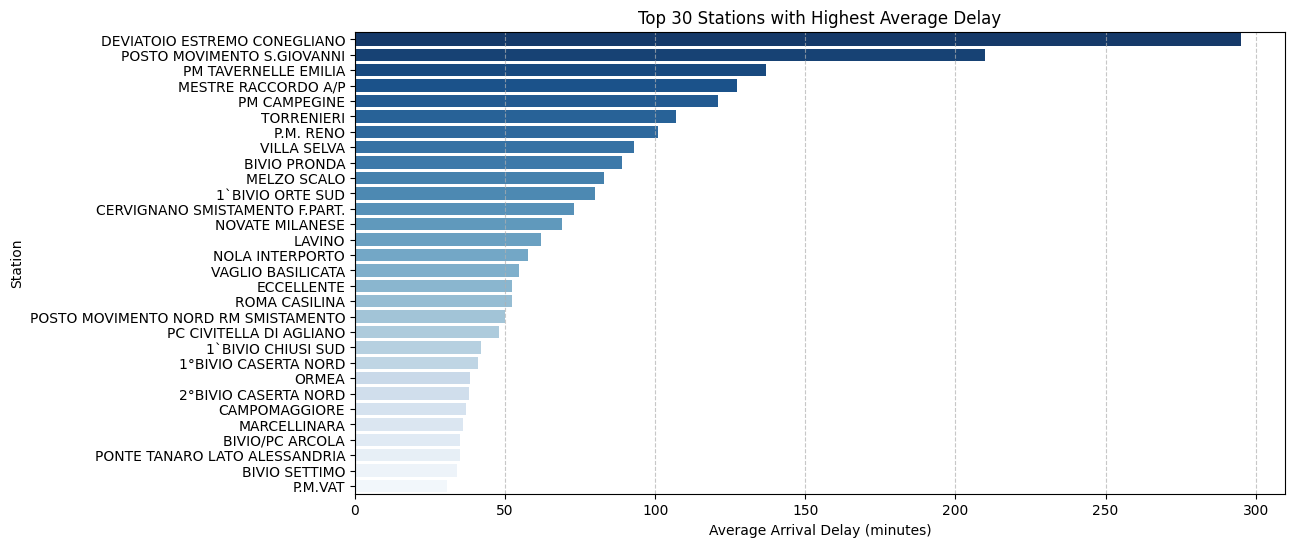

In [6]:
# Compute average delay per station
station_delays = df.groupby("stop_name")["stop_arrival_delay"].mean().sort_values(ascending=False)

station_delays_df = station_delays.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x="stop_arrival_delay", 
    y="stop_name", 
    hue="stop_name",
    data=station_delays_df.head(30), 
    palette="Blues_r", 
    legend=False
)

plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Station")
plt.title("Top 30 Stations with Highest Average Delay")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

**Avoid Bias from Low-Frequency Stations**

While understanding the most congested stations can be important, understanding how important those stations are can also help to assign proper relevance to various stations.

If a station appears only a few times in the dataset, its delay average might be misleading (e.g., one extreme delay could distort results). By setting a minimum threshold (e.g. `min_trains = 100000`), we focus on frequently used stations, improving reliability.

Furthermore, we can test different thresholds to see how congestion changes across high-traffic vs. low-traffic stations.
This might reveal that delays are worse in low-traffic stations due to fewer resources or in high-traffic stations due to congestion.

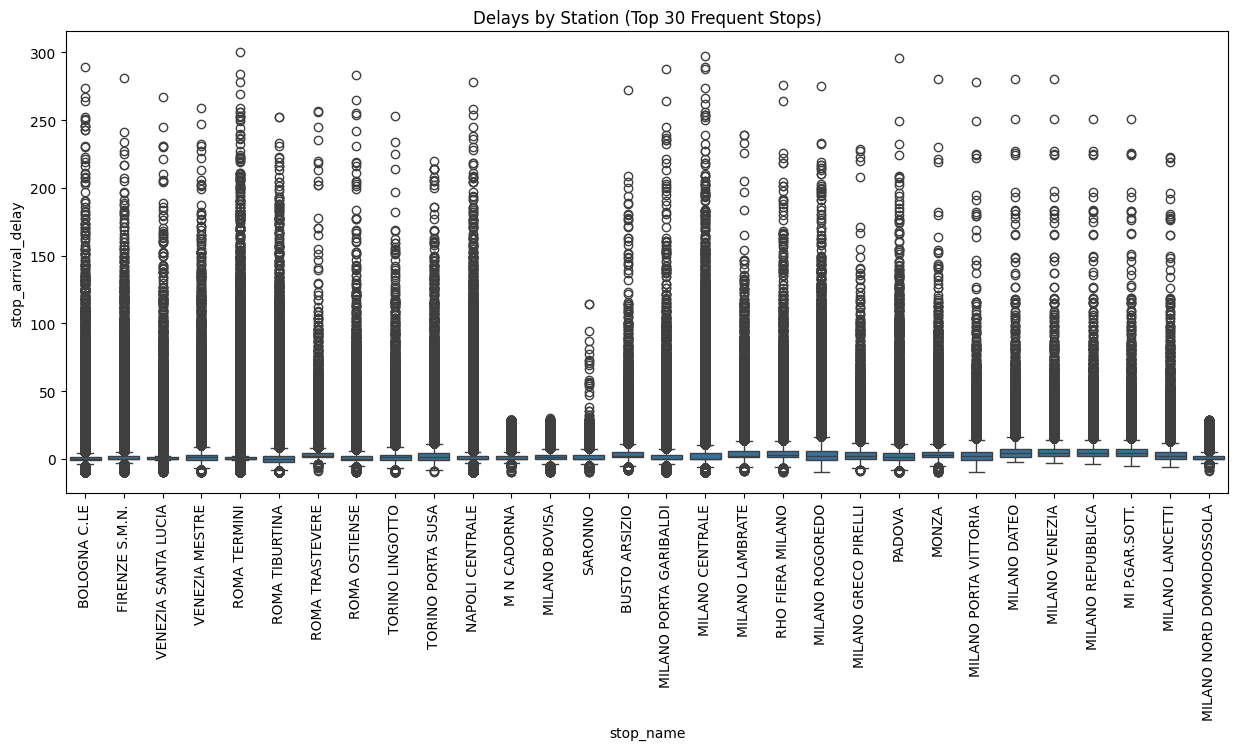

In [7]:
top_30_stations = df["stop_name"].value_counts().head(30).index
df_filtered = df[df["stop_name"].isin(top_30_stations)]

plt.figure(figsize=(15, 6))
sns.boxplot(x="stop_name", y="stop_arrival_delay", data=df_filtered)
plt.xticks(rotation=90)
plt.title("Delays by Station (Top 30 Frequent Stops)")
plt.show()


This boxplot visualizes arrival delays for the 30 most frequent train stops. The blue line inside each box represents the median delay for each station. The box itself represents the interquartile range (IQR), covering the middle 50% of the data. The whiskers extend to 1.5 times the IQR, and outliers (black circles) represent extreme delays.

As we already seen, most stations have a median delay close to 0 minutes, meaning that in general, trains are not significantly delayed.
However, a large number of outliers indicate that severe delays do occur, but they are not the norm.
Also, the density of outliers is high, meaning some stations, more than others, experience extreme delays.

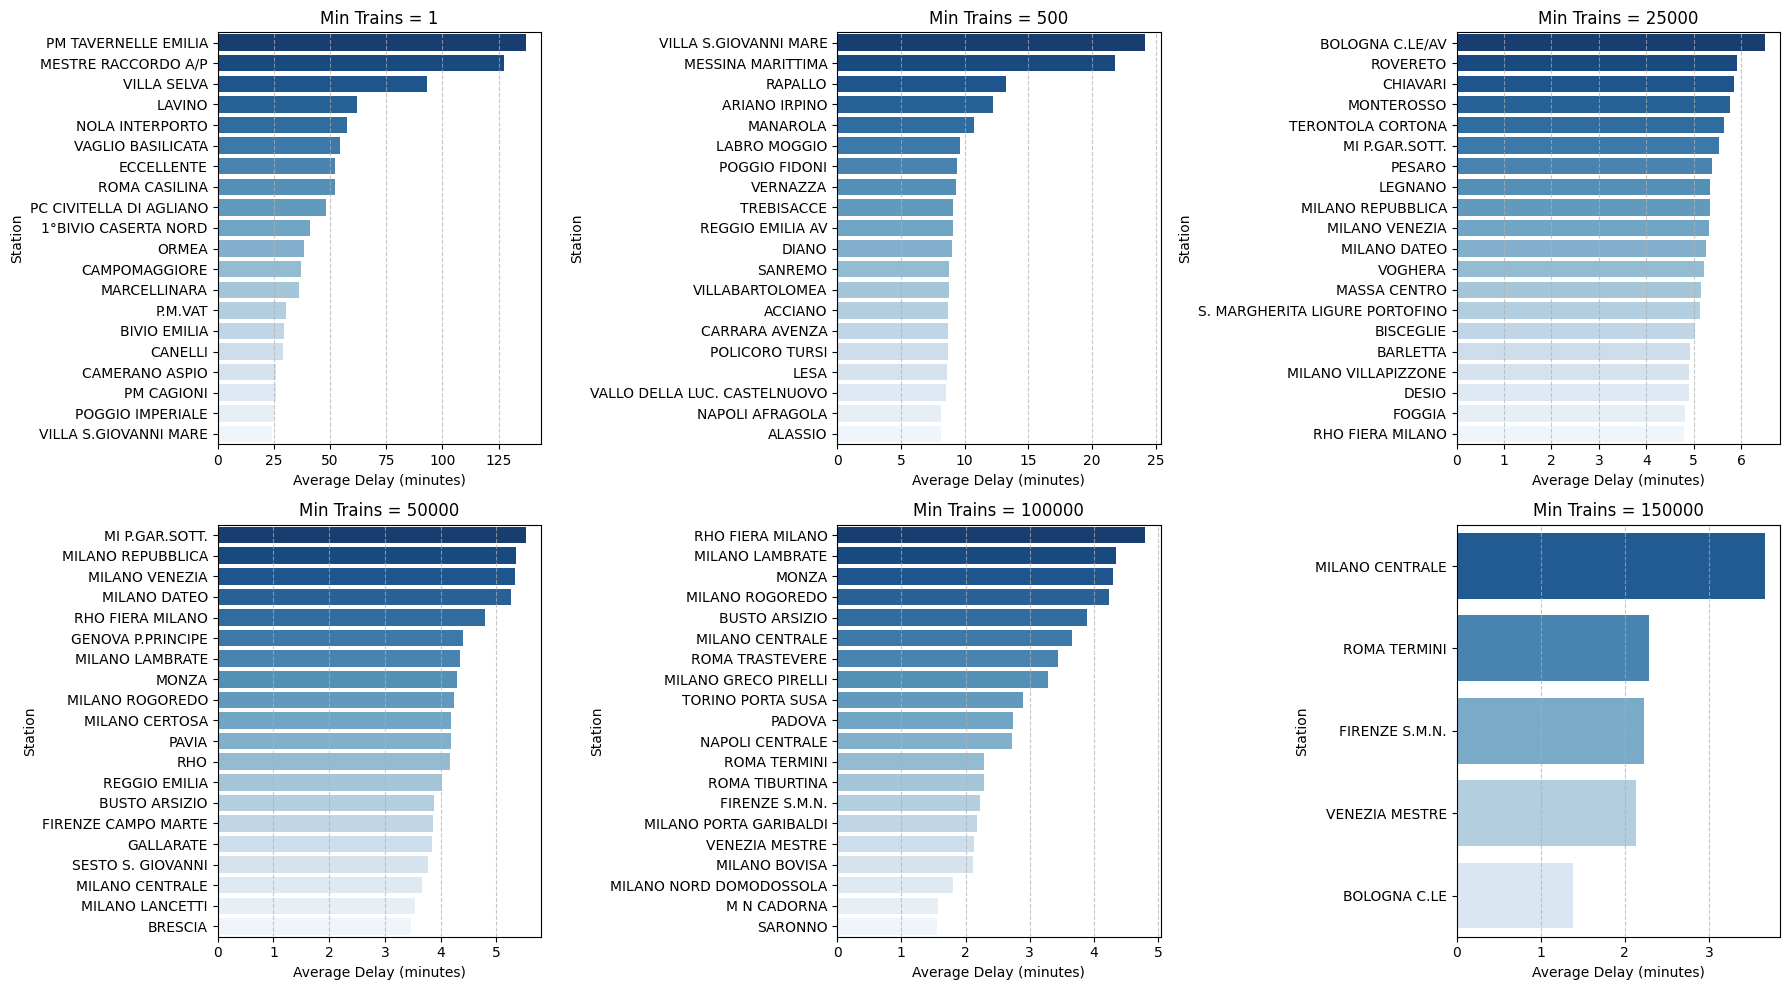

In [8]:
def plot_top_delayed_stations(ax, df, station_delays_df, min_trains):
    station_counts = df["stop_name"].value_counts()
    frequent_stations = station_counts[station_counts > min_trains].index

    filtered_stations = station_delays_df[station_delays_df["stop_name"].isin(frequent_stations)]
    filtered_stations = filtered_stations.sort_values(by="stop_arrival_delay", ascending=False).head(20)

    sns.barplot(
        x="stop_arrival_delay", 
        y="stop_name", 
        hue="stop_name",
        data=filtered_stations, 
        palette="Blues_r", 
        legend=False,
        ax=ax
    )

    ax.set_title(f"Min Trains = {min_trains}")
    ax.set_xlabel("Average Delay (minutes)")
    ax.set_ylabel("Station")
    ax.grid(axis="x", linestyle="--", alpha=0.7)

min_trains_values = [1, 500, 25000, 50000, 100000, 150000]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, min_trains in zip(axes.flatten(), min_trains_values):
    plot_top_delayed_stations(ax, df, station_delays_df, min_trains)

plt.tight_layout()
plt.show()


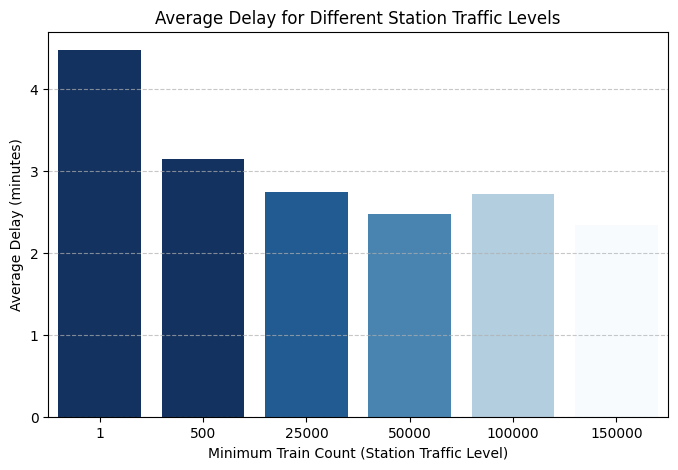

In [9]:
thresholds = [1, 500, 25000, 50000, 100000, 150000]
station_counts = df["stop_name"].value_counts()

delay_results = {}

for min_trains in thresholds:
    frequent_stations = station_counts[station_counts > min_trains].index
    filtered_stations = station_delays_df[station_delays_df["stop_name"].isin(frequent_stations)]
    
    avg_delay = filtered_stations["stop_arrival_delay"].mean()
    
    delay_results[min_trains] = avg_delay

delay_df = pd.DataFrame(list(delay_results.items()), columns=["Min Train Count", "Average Delay"])

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Min Train Count", 
    y="Average Delay", 
    hue="Min Train Count",
    data=delay_df, 
    palette="Blues_r", 
    legend=False
)

plt.title("Average Delay for Different Station Traffic Levels")
plt.xlabel("Minimum Train Count (Station Traffic Level)")
plt.ylabel("Average Delay (minutes)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


As we can see, wen `min_trains_values` is low, the dataset includes many stations with very few train stops. These stations might experience sporadic extreme delays due to operational inefficiencies, accidents, or infrastructure limitations. However, as we increase the threshold (min_trains_values), we filter out these stations, leaving only those with a high number of train stops, which tend to have more stable performance and lower average delays.

If we think about it, stations with few recorded trains are more susceptible to outliers. A single train arriving significantly late at a low-frequency station can drastically inflate the average delay. On the other hand, high-frequency stations have many data points, meaning that extreme values have less impact on the mean, leading to a more stable and generally lower delay value.

Moreover, trains that stop at small stations are often part of long-distance or regional routes, meaning their delays may be caused by factors far from the station itself (e.g., issues at a previous station or along the route). These stations are more vulnerable to accumulated delays. While, on the other hand, stations with a high number of trains are typically located in major cities or central hubs, where railway infrastructure is more developed.

**Analyze Delay Propagation**

Since delays can accumulate along a train's route, let's check if departure delays correlate with arrival delays. If delays tend to propagate, this suggests that earlier stops strongly influence future delays.

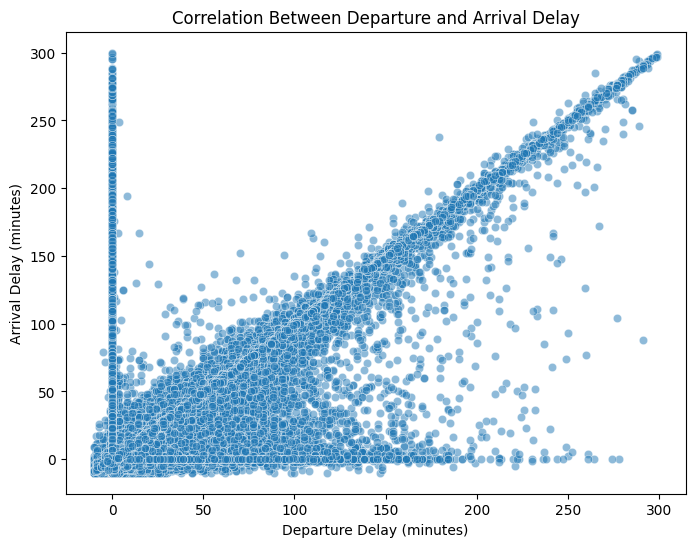

Correlation Matrix:
                       stop_departure_delay  stop_arrival_delay
stop_departure_delay              1.000000            0.860688
stop_arrival_delay                0.860688            1.000000


In [10]:
# Scatter plot of departure delay vs. arrival delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["stop_departure_delay"], y=df["stop_arrival_delay"], alpha=0.5)
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.title("Correlation Between Departure and Arrival Delay")
plt.show()

# Correlation coefficient
correlation = df[["stop_departure_delay", "stop_arrival_delay"]].corr()
print("Correlation Matrix:\n", correlation)


This scatter plot is pretty interesting. 

Each point represents a train stop, and, as we can imagine, the overall trend suggests a positive correlation between the departure delay and the arrival delay.

The dense diagonal pattern suggests that trains with a high departure delay often retain a similar level of delay upon arrival

We can see also a significant concentration of points at `x = 0` (departure delay = 0). This indicates that many trains depart on time, but their arrival delays vary widely, from 0 minutes up to over 300 minutes. This is interesting because it suggests that factors beyond departure delay (e.g., track congestion, weather, technical issues) contribute to arrival delay.

On the other hand, while many points fall along the diagonal, there is also a spread of points below the diagonal, indicating cases where trains departed late but managed to recover part of the delay before arriving at their destination.  

Some points are far above the main trend, meaning a few trains had relatively small departure delays but extreme arrival delays. This suggests that even minor initial delays can escalate significantly.

## **Time-Series Trends & Seasonality**

Another interesting aspect to analyze is how delays are distributed over time. Understanding the temporal patterns of delays can help identify underlying causes, optimize scheduling, and improve train service efficiency.

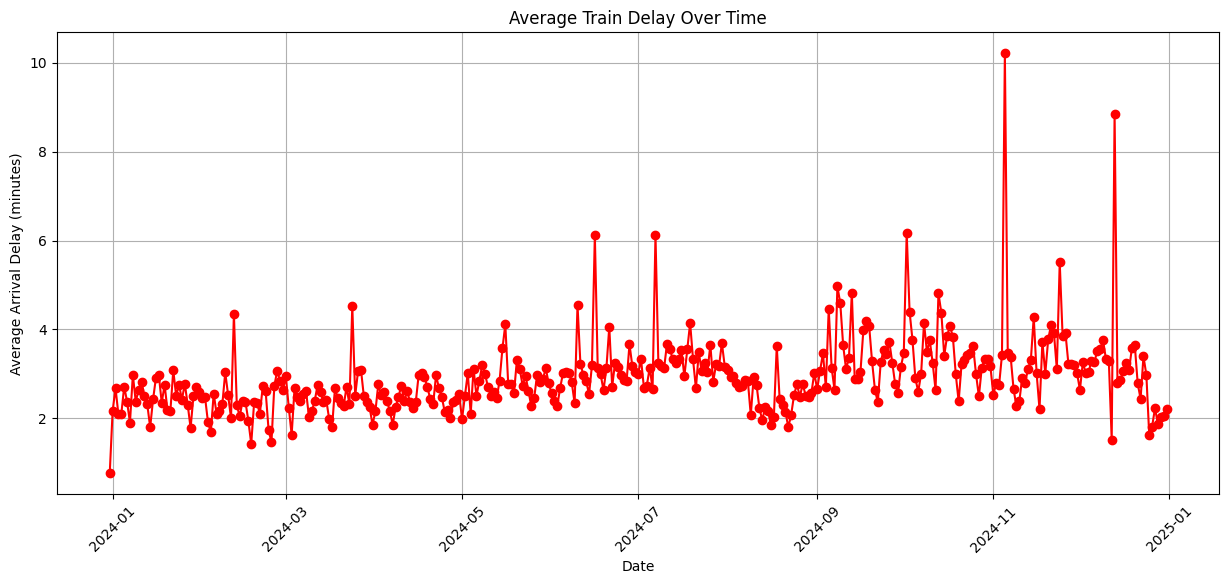

In [11]:
df["scheduled_departure_date"] = df["scheduled_departure_time"].dt.date

daily_delays = df.groupby("scheduled_departure_date")["stop_arrival_delay"].mean()

plt.figure(figsize=(15, 6))
plt.plot(daily_delays, marker="o", linestyle="-", color="red")
plt.title("Average Train Delay Over Time")
plt.xlabel("Date")
plt.ylabel("Average Arrival Delay (minutes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


This plot represents the average daily train arrival delay over time. 

Generally speaking, the delays remain relatively table in the first half of the year, fluctuating around 2-3 minutes on average.
In the second half, there is a noticeable increase in delays, with more frequent peaks and greater variability.

Several sharp spikes appear throughout the year, particularly in July, November, and December, where delays exceed 6-10 minutes.
These peaks could be caused by seasonal disruptions, such as extreme weather, increased passenger loads during holidays, or maintenance work.

**Delays by Month**

Analyzing delays by month helps us detect seasonal trends and weather impacts on train punctuality. For example, the winter months may show more delays due to snow, ice, and fog affecting train operations. On the other hand, summer months might have heat-related issues.
Furthermore, holiday seasons (December, August, etc.) could impact delays due to changing travel volumes.

If delays vary significantly by month, we can add seasonal features to the model, such as season category (Winter, Spring, Summer, Fall) or monthly delay trends to improve predictions.

In [12]:
# Extract time components
df["hour"] = df["scheduled_departure_time"].dt.hour
df["day_of_week"] = df["scheduled_departure_time"].dt.dayofweek  # Monday = 0, Sunday = 6
df["month"] = df["scheduled_departure_time"].dt.month

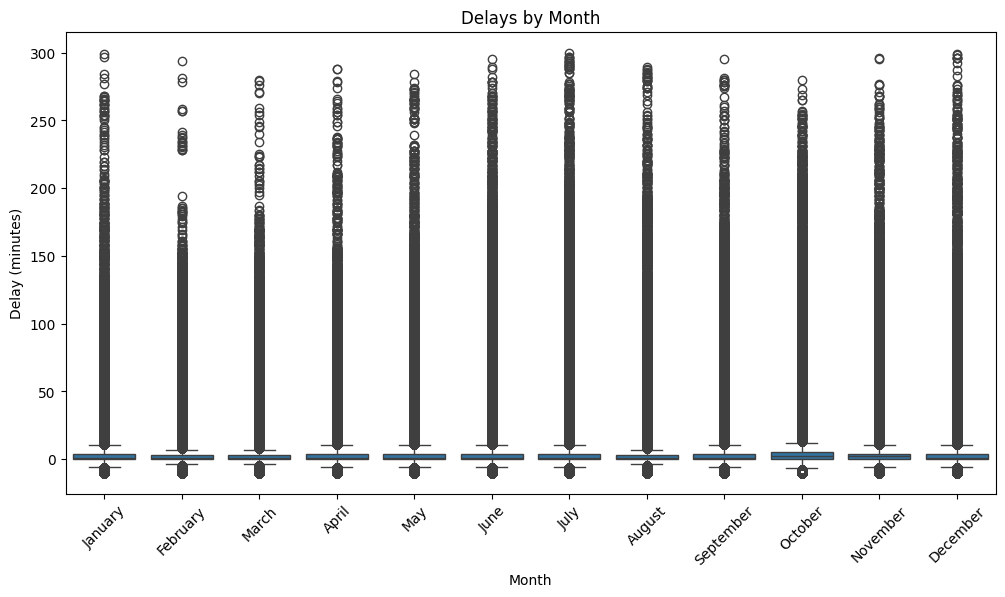

In [13]:
# Plot delays by month of the year
df["month"] = df["scheduled_departure_time"].dt.month_name()

plt.figure(figsize=(12, 6))
sns.boxplot(x="month", y="stop_arrival_delay", data=df, order=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])
plt.title("Delays by Month")
plt.xlabel("Month")
plt.ylabel("Delay (minutes)")
plt.xticks(rotation=45)
plt.show()

This plot basically confirms what was observed with the year-round overview, indicating July, November and December as months particularly characterized by delays.

**Delays by Day of the Week**

This can reveal weekday vs weekend effects.
If delays spike on Mondays or Fridays, it may be due to high passenger demand or operational bottlenecks.

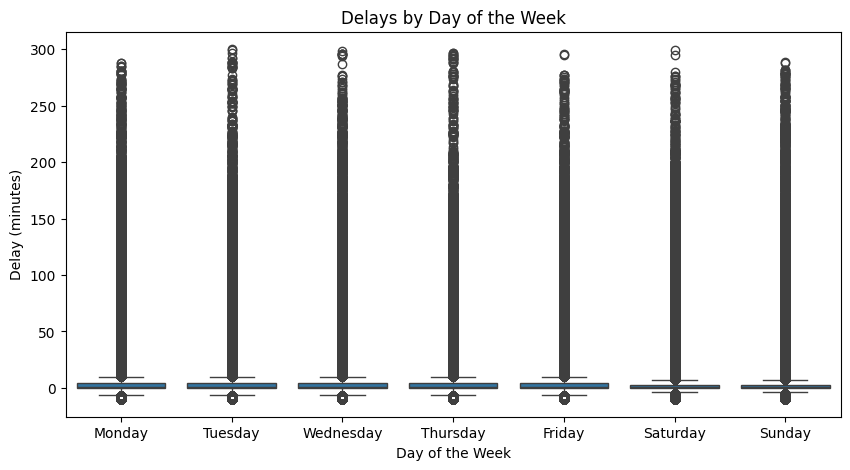

In [14]:
df["day_of_week"] = df["scheduled_departure_time"].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x="day_of_week", y="stop_arrival_delay", data=df, order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.title("Delays by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Delay (minutes)")
plt.show()

In this week's plot, the interquartile range, represented by the height of the boxes for Saturday and Sunday, is smaller than those of the weekdays. This indicates that the middle 50% of the delay times on weekends have a narrower spread. In other words, the delays during the weekend tend to be more clustered around the median.

Also the whiskers for Saturday and Sunday are also shorter than those of the weekdays. This suggests that the typical range of delays (excluding outliers) is smaller on weekends. The delays are less dispersed and more concentrated within a smaller interval.

It's important to note that even though the boxes and whiskers are smaller on weekends, there are still outliers present. This means that even on Saturdays and Sundays, there are still instances of significantly longer or shorter delays, although they might be relatively less frequent or less extreme compared to weekdays.



**Delays by hour**

Analyzing delays by hour helps identify rush hour congestion, delay propagation (and further weather effects). If peak hours show more delays, we can add a rush hour feature. If delays accumulate throughout the day, we might track previous train delays.

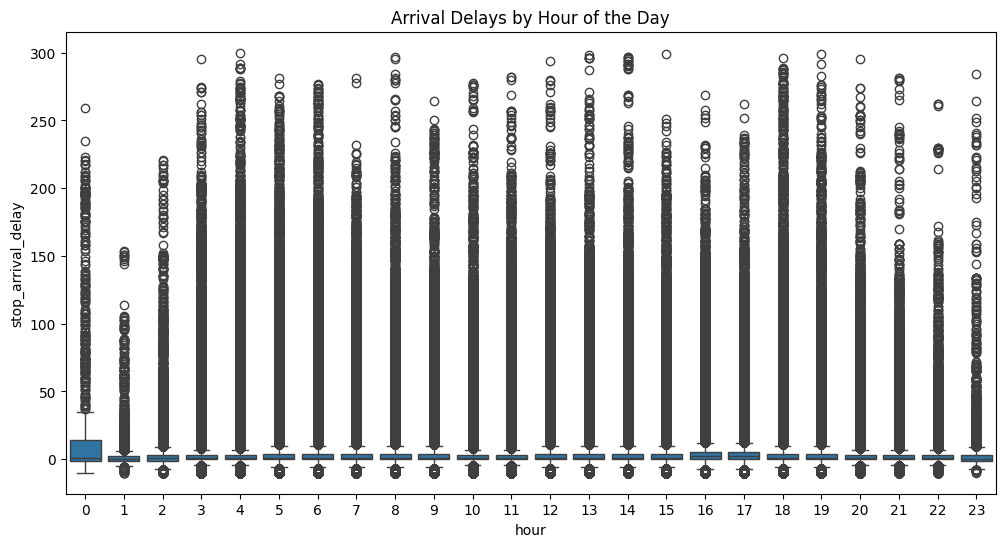

In [15]:
# Plot delays by hour
plt.figure(figsize=(12,6))
sns.boxplot(x="hour", y="stop_arrival_delay", data=df)
plt.title("Arrival Delays by Hour of the Day")
plt.show()

Across all hours, there are extreme delays, as we can see from the numerous scattered points above each box.

During the nighttime (8 p.m. - 4 a.m.) the number of extreme outliers is noticeably lower compared to other periods.
This could be due to reduced train frequency, meaning that fewer trains are recorded, leading to fewer extreme delay instances.

Around 6 p.m. we can see a particularly high density of outliers, indicating that many trains experience severe delays.
A possible explanation is increased passenger demand, leading to higher congestion and operational slowdowns.